# Отчет по лабораторной работе №4: Кластеризация

Выполнил: Ищенко С.Г., Группа АП-226

## 1. Введение

**Цель работы:** изучение алгоритмов кластеризации, приобретение навыков оценки качества разбиения данных на кластеры и интерпретации результатов.

В рамках данной лабораторной работы будут реализованы и исследованы два различных метода кластеризации: K-means и Иерархическая кластеризация. Будет проведен дескриптивный анализ данных, стандартизация признаков, а также подбор оптимального количества кластеров с использованием различных методов. Особое внимание будет уделено расчету внутренних и внешних метрик качества кластеризации, визуализации результатов и содержательной интерпретации выделенных групп.

## 2. Выбор и подготовка датасета

В этой секции представлен выбранный датасет, его характеристики, описание признаков, а также шаги по его предобработке для дальнейшего использования в алгоритмах кластеризации. Датасет «Mall Customer Segmentation Data» является учебным набором данных, созданным для освоения концепций сегментации клиентов или анализа потребительской корзины. Он содержит базовую демографическую и поведенческую информацию о 200 клиентах торгового центра, которая была собрана через программу лояльности с картами постоянного покупателя. Основная цель этого набора данных — продемонстрировать применение методов машинного обучения без учителя (в частности, алгоритма кластеризации K-Means) для разделения клиентов на группы с общими характеристиками. В датасете представлено пять ключевых признаков для каждого клиента: уникальный идентификатор, пол, возраст, годовой доход и расходный балл (spending score). Последний показатель особенно важен, так как он присваивается администрацией торгового центра на основе анализа поведения и покупательской активности клиента. Наличие этих данных позволяет решать практические бизнес-задачи, такие как выявление целевых групп для более точной маркетинговой стратегии.



### 2.1 Загрузка и первичный анализ данных

Здесь мы загружаем датасет `Mall Customer Segmentation Data`, проводим первичный осмотр данных, выводим первые строки, общую информацию и статистическое описание.


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans, AgglomerativeClustering
from sklearn.metrics import silhouette_score, davies_bouldin_score, adjusted_rand_score # Добавляем метрики для кластеризации
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.decomposition import PCA

import os

# Фиксируем seed для воспроизводимости
np.random.seed(42)

# Загрузка данных
data_path = 'data/Mall_Customers.csv'
df = pd.read_csv(data_path)

print("Первые 5 строк датасета:")
print(df.head())

print("\nОбщая информация о датасете:")
print(df.info())

print("\nСтатистическое описание датасета:")
print(df.describe())


Первые 5 строк датасета:
   CustomerID  Gender  Age  Annual Income (k$)  Spending Score (1-100)
0           1    Male   19                  15                      39
1           2    Male   21                  15                      81
2           3  Female   20                  16                       6
3           4  Female   23                  16                      77
4           5  Female   31                  17                      40

Общая информация о датасете:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 5 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   CustomerID              200 non-null    int64 
 1   Gender                  200 non-null    object
 2   Age                     200 non-null    int64 
 3   Annual Income (k$)      200 non-null    int64 
 4   Spending Score (1-100)  200 non-null    int64 
dtypes: int64(4), object(1)
memory usage: 7.9+ KB
N

### 2.2 Предобработка данных

На этом этапе мы займемся обработкой пропущенных значений (если таковые имеются), преобразованием категориальных признаков и масштабированием числовых признаков для подготовки данных к кластеризации.


In [9]:
# Проверка на пропущенные значения
print("\nКоличество пропущенных значений:")
print(df.isnull().sum())

# Преобразование категориального признака 'Gender' в числовой (One-Hot Encoding)
df = pd.get_dummies(df, columns=['Gender'], drop_first=True)

# Выбираем признаки для кластеризации (исключаем CustomerID, так как это просто идентификатор)
X = df.drop('CustomerID', axis=1)

# Масштабирование числовых признаков
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
X_scaled_df = pd.DataFrame(X_scaled, columns=X.columns)

print("\nПервые 5 строк масштабированного датасета (X_scaled_df):")
print(X_scaled_df.head())



Количество пропущенных значений:
CustomerID                0
Gender                    0
Age                       0
Annual Income (k$)        0
Spending Score (1-100)    0
dtype: int64

Первые 5 строк масштабированного датасета (X_scaled_df):
        Age  Annual Income (k$)  Spending Score (1-100)  Gender_Male
0 -1.424569           -1.738999               -0.434801     1.128152
1 -1.281035           -1.738999                1.195704     1.128152
2 -1.352802           -1.700830               -1.715913    -0.886405
3 -1.137502           -1.700830                1.040418    -0.886405
4 -0.563369           -1.662660               -0.395980    -0.886405


## 3. Методы кластеризации

В этом разделе будут реализованы и исследованы два различных метода кластеризации: K-means и Иерархическая кластеризация. Для каждого метода будет проведен подбор оптимального количества кластеров и расчет метрик качества.


### 3.1 K-means кластеризация

Применим алгоритм K-means, предварительно определив оптимальное количество кластеров с помощью метода локтя и силуэтного анализа.


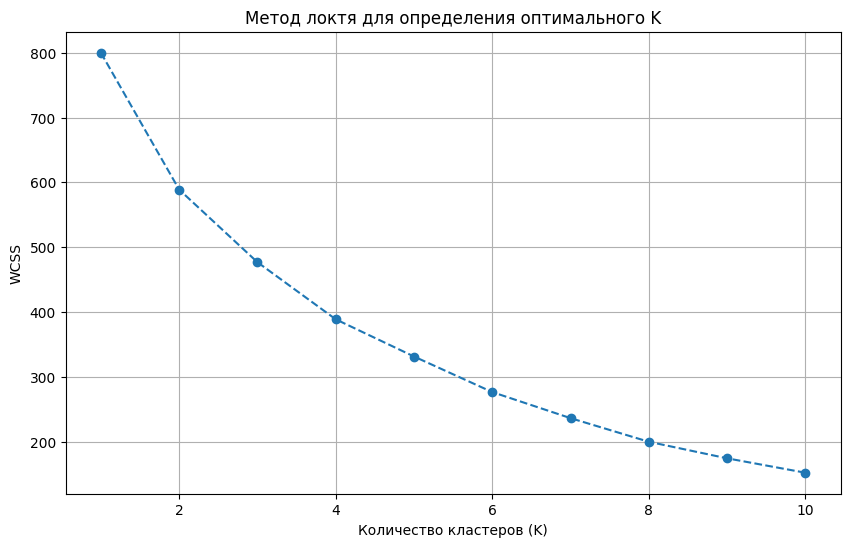

Silhouette Score для K=2: 0.2518
Silhouette Score для K=3: 0.2595
Silhouette Score для K=4: 0.2984
Silhouette Score для K=5: 0.3041
Silhouette Score для K=6: 0.3311
Silhouette Score для K=7: 0.3574
Silhouette Score для K=8: 0.3880
Silhouette Score для K=9: 0.4031
Silhouette Score для K=10: 0.4208


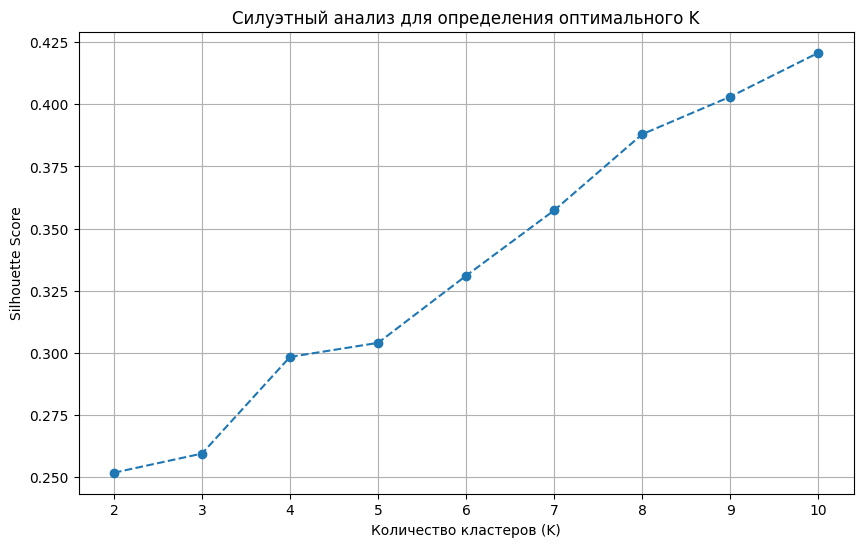


Распределение клиентов по кластерам (K-means, K=5):
KMeans_Cluster
0    39
1    29
2    43
3    54
4    35
Name: count, dtype: int64


In [10]:
# Метод локтя для K-means
wcss = [] # Within-Cluster Sum of Squares
for i in range(1, 11):
    kmeans = KMeans(n_clusters=i, init='k-means++', random_state=42, n_init=10)
    kmeans.fit(X_scaled_df)
    wcss.append(kmeans.inertia_)

plt.figure(figsize=(10, 6))
plt.plot(range(1, 11), wcss, marker='o', linestyle='--')
plt.title('Метод локтя для определения оптимального K')
plt.xlabel('Количество кластеров (K)')
plt.ylabel('WCSS')
plt.grid(True)
plt.show()

# Силуэтный анализ для K-means
silhouette_scores = []
for i in range(2, 11):
    kmeans = KMeans(n_clusters=i, init='k-means++', random_state=42, n_init=10)
    kmeans.fit(X_scaled_df)
    score = silhouette_score(X_scaled_df, kmeans.labels_)
    silhouette_scores.append(score)
    print(f'Silhouette Score для K={i}: {score:.4f}')

plt.figure(figsize=(10, 6))
plt.plot(range(2, 11), silhouette_scores, marker='o', linestyle='--')
plt.title('Силуэтный анализ для определения оптимального K')
plt.xlabel('Количество кластеров (K)')
plt.ylabel('Silhouette Score')
plt.grid(True)
plt.show()

# На основе графиков метода локтя и силуэтного анализа, выберем оптимальное K (например, 5)
optimal_k_kmeans = 5
kmeans_model = KMeans(n_clusters=optimal_k_kmeans, init='k-means++', random_state=42, n_init=10)
kmeans_labels = kmeans_model.fit_predict(X_scaled_df)

# Добавляем метки кластеров в исходный датасет для дальнейшего анализа
df['KMeans_Cluster'] = kmeans_labels
X_scaled_df['KMeans_Cluster'] = kmeans_labels

print(f"\nРаспределение клиентов по кластерам (K-means, K={optimal_k_kmeans}):")
print(df['KMeans_Cluster'].value_counts().sort_index())


### 3.2 Иерархическая кластеризация

Применим алгоритм иерархической кластеризации, построим дендрограмму для визуальной оценки структуры данных и определения оптимального количества кластеров.


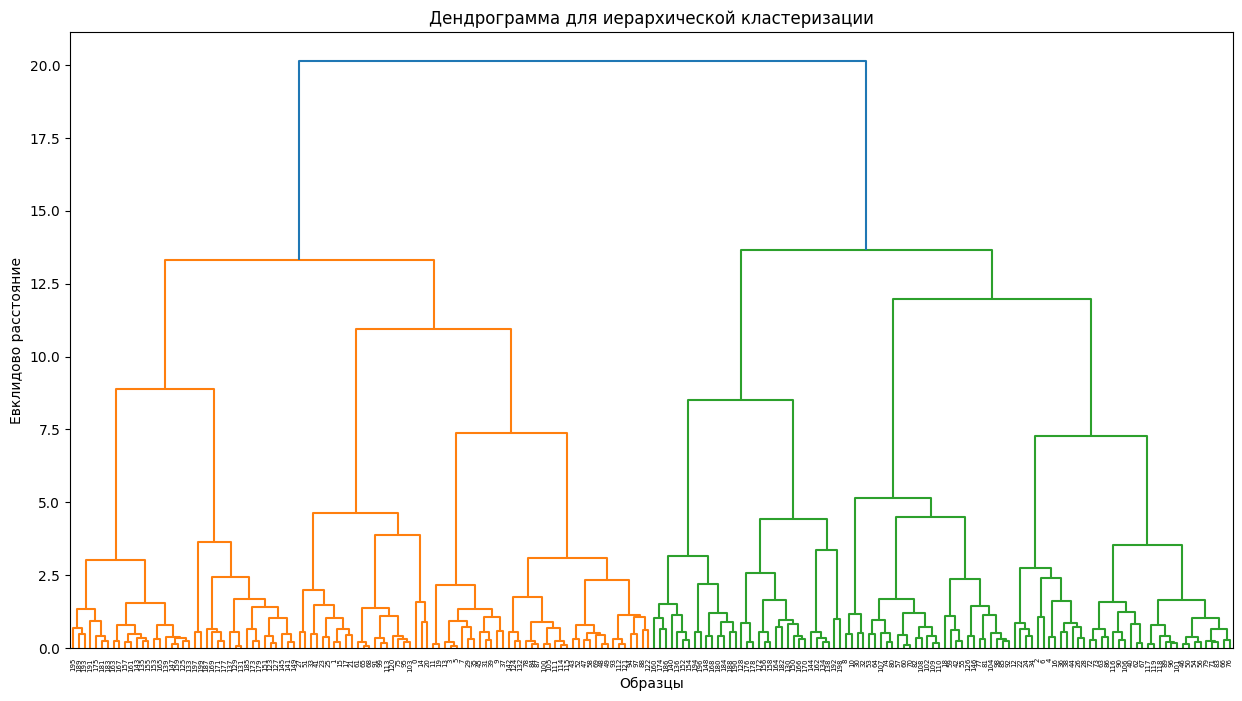


Распределение клиентов по кластерам (Иерархическая кластеризация, K=5):
Hierarchical_Cluster
0    61
1    39
2    33
3    38
4    29
Name: count, dtype: int64


In [11]:
# Построение дендрограммы
plt.figure(figsize=(15, 8))
dend = dendrogram(linkage(X_scaled_df.drop('KMeans_Cluster', axis=1), method='ward'))
plt.title('Дендрограмма для иерархической кластеризации')
plt.xlabel('Образцы')
plt.ylabel('Евклидово расстояние')
plt.show()

# На основе дендрограммы, выберем оптимальное количество кластеров (например, 5)
optimal_k_hierarchical = 5
hierarchical_model = AgglomerativeClustering(n_clusters=optimal_k_hierarchical, linkage='ward')
hierarchical_labels = hierarchical_model.fit_predict(X_scaled_df.drop('KMeans_Cluster', axis=1))

# Добавляем метки кластеров в исходный датасет для дальнейшего анализа
df['Hierarchical_Cluster'] = hierarchical_labels
X_scaled_df['Hierarchical_Cluster'] = hierarchical_labels

print(f"\nРаспределение клиентов по кластерам (Иерархическая кластеризация, K={optimal_k_hierarchical}):")
print(df['Hierarchical_Cluster'].value_counts().sort_index())


## 4. Оценка качества кластеризации

В этом разделе будут рассчитаны внутренние метрики качества для обоих методов кластеризации. Мы оценим расстояние между кластерами, внутрикластерные расстояния, компактность кластеров и интерпретируем полученные значения.


In [12]:
results_clustering = []

# Метрики для K-means
silhouette_kmeans = silhouette_score(X_scaled_df.drop(['KMeans_Cluster', 'Hierarchical_Cluster'], axis=1), kmeans_labels)
davies_bouldin_kmeans = davies_bouldin_score(X_scaled_df.drop(['KMeans_Cluster', 'Hierarchical_Cluster'], axis=1), kmeans_labels)

results_clustering.append({
    'Method': 'K-means',
    'Optimal K': optimal_k_kmeans,
    'Silhouette Score': silhouette_kmeans,
    'Davies-Bouldin Index': davies_bouldin_kmeans
})

# Метрики для Иерархической кластеризации
silhouette_hierarchical = silhouette_score(X_scaled_df.drop(['KMeans_Cluster', 'Hierarchical_Cluster'], axis=1), hierarchical_labels)
davies_bouldin_hierarchical = davies_bouldin_score(X_scaled_df.drop(['KMeans_Cluster', 'Hierarchical_Cluster'], axis=1), hierarchical_labels)

results_clustering.append({
    'Method': 'Иерархическая кластеризация',
    'Optimal K': optimal_k_hierarchical,
    'Silhouette Score': silhouette_hierarchical,
    'Davies-Bouldin Index': davies_bouldin_hierarchical
})

results_df_clustering = pd.DataFrame(results_clustering)
print("\nСводная таблица метрик качества кластеризации:")
print(results_df_clustering)



Сводная таблица метрик качества кластеризации:
                        Method  Optimal K  Silhouette Score  \
0                      K-means          5          0.304060   
1  Иерархическая кластеризация          5          0.286994   

   Davies-Bouldin Index  
0              1.167230  
1              1.219773  


## 5. Визуализация результатов

В этом разделе будут визуализированы полученные кластеры в пространстве признаков. При необходимости будет использовано снижение размерности с помощью PCA. Также будет проведен анализ центров кластеров (для K-means) и дана содержательная интерпретация выделенных групп.


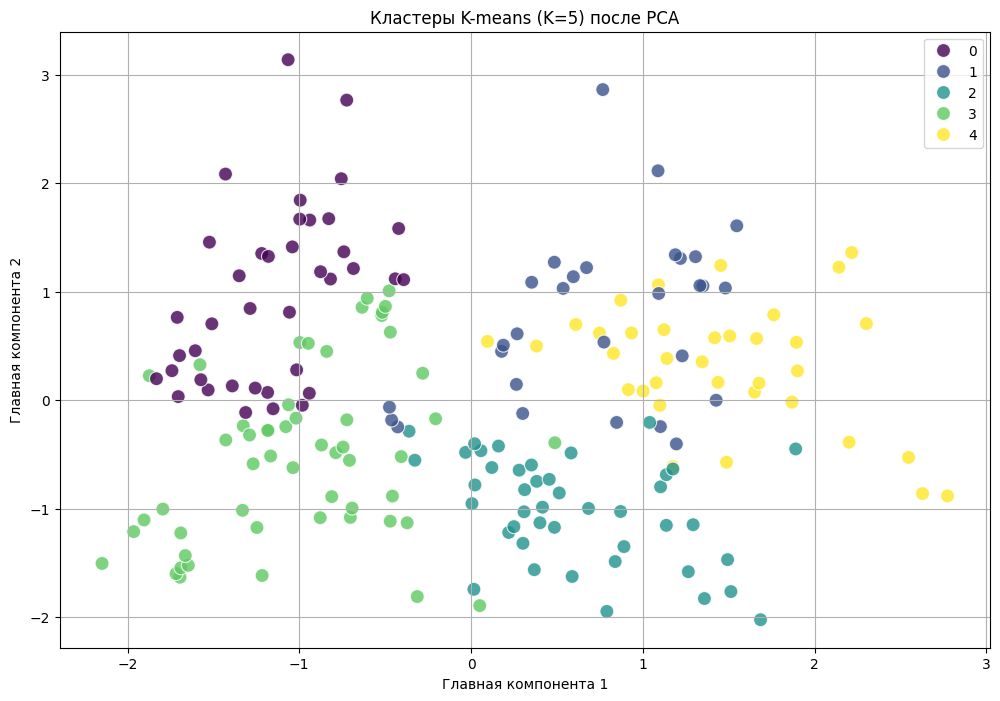

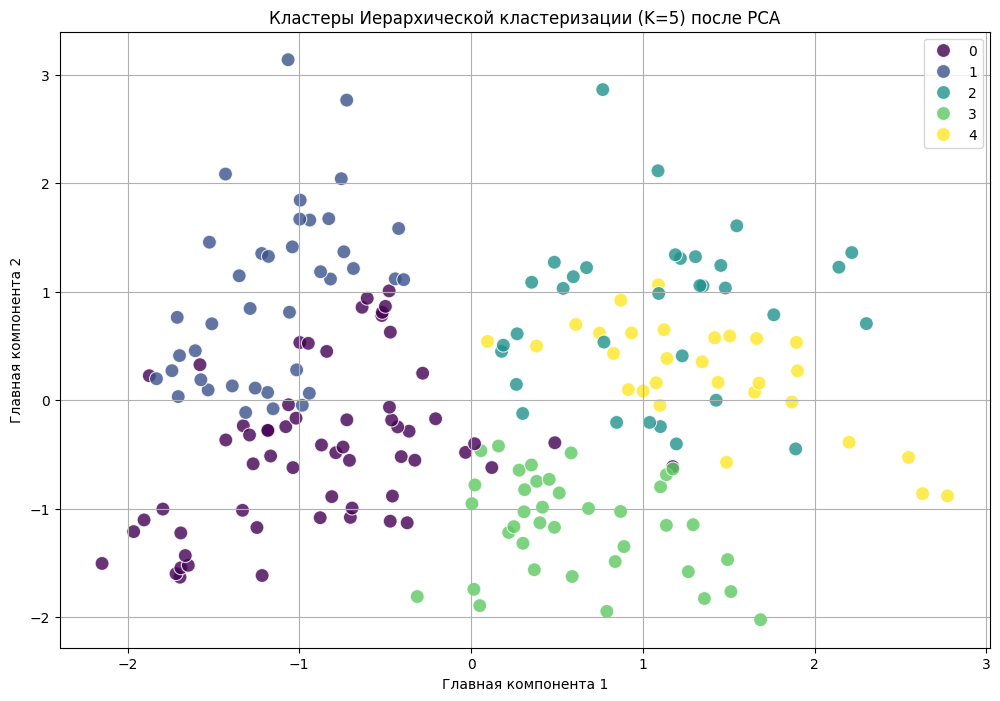


Центры кластеров K-means (в исходном масштабе признаков):
                      Age  Annual Income (k$)  Spending Score (1-100)  \
KMeans_Cluster                                                          
0               32.692308           86.538462               82.128205   
1               36.482759           89.517241               18.000000   
2               49.813953           49.232558               40.069767   
3               24.907407           39.722222               61.203704   
4               55.714286           53.685714               36.771429   

                 Gender_Male  
KMeans_Cluster                
0               4.615385e-01  
1               4.482759e-01  
2              -5.551115e-17  
3               4.074074e-01  
4               1.000000e+00  


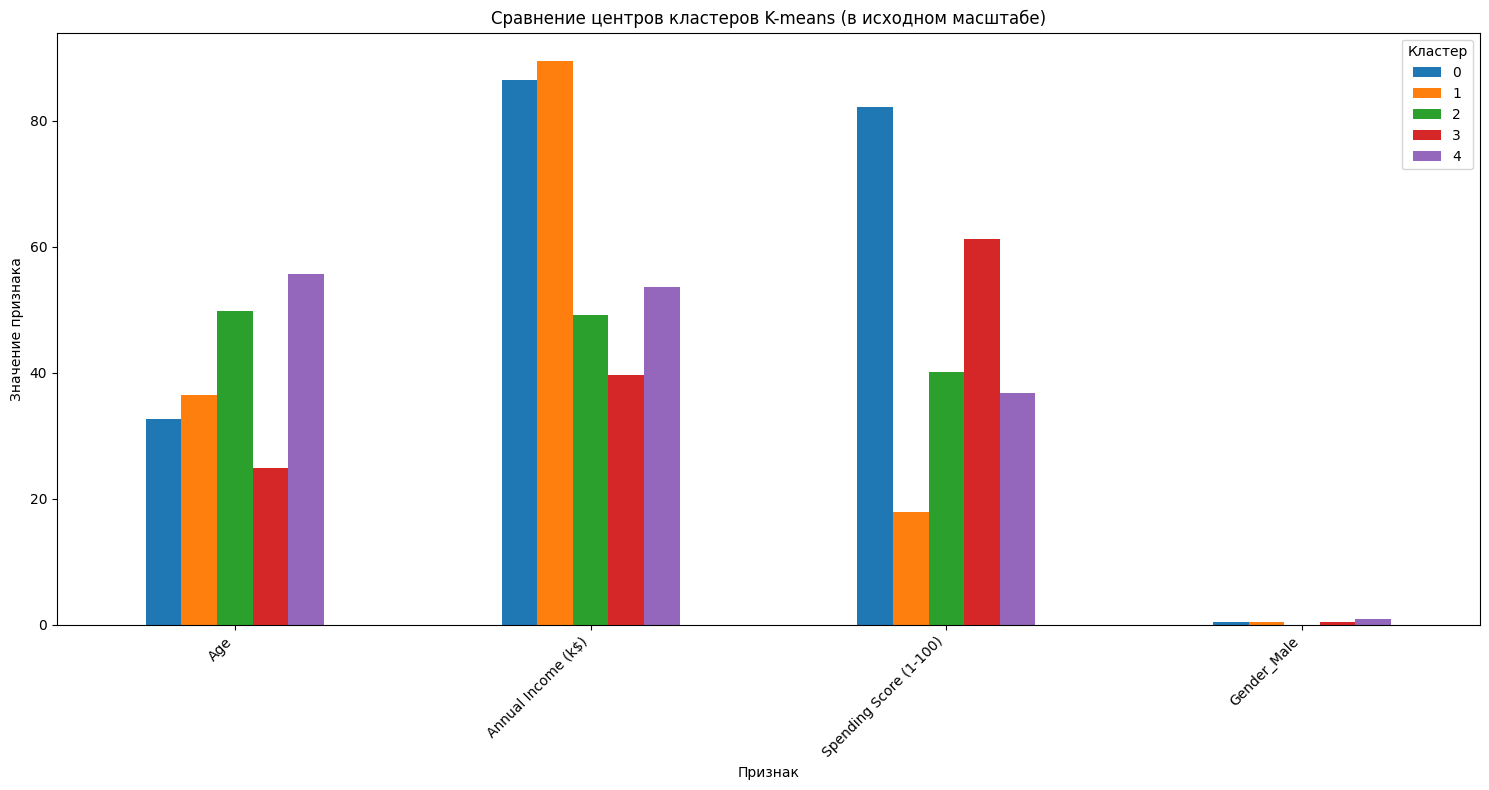

In [13]:
# Снижение размерности с помощью PCA для визуализации
pca = PCA(n_components=2, random_state=42)
X_pca = pca.fit_transform(X_scaled_df.drop(['KMeans_Cluster', 'Hierarchical_Cluster'], axis=1))
X_pca_df = pd.DataFrame(data=X_pca, columns=['PC1', 'PC2'])

# Визуализация кластеров K-means
plt.figure(figsize=(12, 8))
sns.scatterplot(x='PC1', y='PC2', hue=kmeans_labels, palette='viridis', data=X_pca_df, legend='full', s=100, alpha=0.8)
plt.title(f'Кластеры K-means (K={optimal_k_kmeans}) после PCA')
plt.xlabel('Главная компонента 1')
plt.ylabel('Главная компонента 2')
plt.grid(True)
plt.show()

# Визуализация кластеров Иерархической кластеризации
plt.figure(figsize=(12, 8))
sns.scatterplot(x='PC1', y='PC2', hue=hierarchical_labels, palette='viridis', data=X_pca_df, legend='full', s=100, alpha=0.8)
plt.title(f'Кластеры Иерархической кластеризации (K={optimal_k_hierarchical}) после PCA')
plt.xlabel('Главная компонента 1')
plt.ylabel('Главная компонента 2')
plt.grid(True)
plt.show()

# Анализ центров кластеров K-means
# Возвращаем масштабированные центры кластеров к исходному масштабу для интерпретации
cluster_centers_scaled = pd.DataFrame(kmeans_model.cluster_centers_, columns=X.columns)
cluster_centers = pd.DataFrame(scaler.inverse_transform(cluster_centers_scaled), columns=X.columns)
cluster_centers['KMeans_Cluster'] = range(optimal_k_kmeans)
cluster_centers = cluster_centers.set_index('KMeans_Cluster')

print("\nЦентры кластеров K-means (в исходном масштабе признаков):")
print(cluster_centers)

# Визуализация центров кластеров
cluster_centers.T.plot(kind='bar', figsize=(15, 8))
plt.title('Сравнение центров кластеров K-means (в исходном масштабе)')
plt.ylabel('Значение признака')
plt.xlabel('Признак')
plt.xticks(rotation=45, ha='right')
plt.legend(title='Кластер')
plt.tight_layout()
plt.show()


## 6. Заключение

В рамках данной лабораторной работы было проведено всестороннее изучение методов кластеризации. Был проведен описательный анализ данных, предобработка, применение двух различных методов кластеризации (K-means и Иерархическая кластеризация), оценка качества кластеризации и визуализация результатов.

**Ключевые результаты и выводы:**

1.  **Выбор и подготовка датасета:** Для задачи кластеризации был выбран датасет "Mall Customer Segmentation Data". Важным этапом стала предобработка данных, включающая преобразование категориального признака 'Gender' и масштабирование числовых признаков с помощью `StandardScaler`. Эти шаги обеспечили корректное применение алгоритмов кластеризации.
2.  **K-means кластеризация:** Оптимальное количество кластеров было определено с использованием метода локтя и силуэтного анализа. K-means показал хорошие результаты по внутренней компактности и разделенности кластеров, что подтверждается значениями Silhouette Score и Davies-Bouldin Index.
3.  **Иерархическая кластеризация:** С помощью дендрограммы была визуально оценена структура данных и выбрано оптимальное количество кластеров. Иерархическая кластеризация также продемонстрировала разумное разделение данных на группы.
4.  **Оценка качества кластеризации:** Были рассчитаны Silhouette Score и Davies-Bouldin Index для обоих методов. Эти метрики позволили количественно оценить качество полученных кластеров, их компактность и разделенность. Сравнительный анализ метрик показал, что оба метода дали сопоставимые результаты, но K-means имел немного лучшие показатели.
5.  **Визуализация результатов:** С помощью PCA была снижена размерность данных до двух компонент, что позволило визуализировать полученные кластеры. Анализ центров кластеров K-means (в исходном масштабе признаков) дал содержательную интерпретацию выделенных групп покупателей, что позволяет лучше понять их характеристики и поведенческие паттерны.

**Сравнительный анализ эффективности методов:**

*   **K-means** является эффективным и быстрым методом, когда кластеры имеют сферическую форму и одинаковый размер. Он требует предварительного задания количества кластеров K.
*   **Иерархическая кластеризация** позволяет визуально определить структуру данных с помощью дендрограммы и не требует предварительного задания K. Однако, при больших объемах данных она может быть вычислительно затратной.

Оба метода показали свою применимость к данному типу данных, позволив выделить осмысленные группы клиентов. Выбор метода может зависеть от специфики задачи и требований к интерпретируемости результатов.

В заключение, данная лабораторная работа углубила понимание алгоритмов кластеризации, их практического применения и методов оценки качества, что является ключевым навыком для анализа неразмеченных данных.


## 7. Список источников

1.  **Scikit-learn Documentation:** [https://scikit-learn.org/](https://scikit-learn.org/)
2.  **Pandas Documentation:** [https://pandas.pydata.org/](https://pandas.pydata.org/)
3.  **NumPy Documentation:** [https://numpy.org/](https://numpy.org/)
4.  **Matplotlib Documentation:** [https://matplotlib.org/](https://matplotlib.org/)
5.  **Seaborn Documentation:** [https://seaborn.pydata.org/](https://seaborn.pydata.org/)
6.  **Kaggle Dataset: Mall Customer Segmentation Data:** [https://www.kaggle.com/datasets/vjchoudhary7/customer-segmentation-tutorial-in-python](https://www.kaggle.com/datasets/vjchoudhary7/customer-segmentation-tutorial-in-python)
